In [6]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [7]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

unnorm_fn = lambda x: (x * torch.tensor([0.229, 0.224, 0.225])) + torch.tensor([0.485, 0.456, 0.406])

def show_image(img, plt, unnormalize=True):
    img = img.permute((1,2,0))
    if unnormalize:
        img = unnorm_fn(img).clamp(0, 1)
    npimg = np.asarray(img)
    print(npimg.shape)
    # plt.figure(figsize = (10,10))
    plt.imshow(npimg, interpolation='nearest')

(512, 512, 3)
(512, 512, 3)


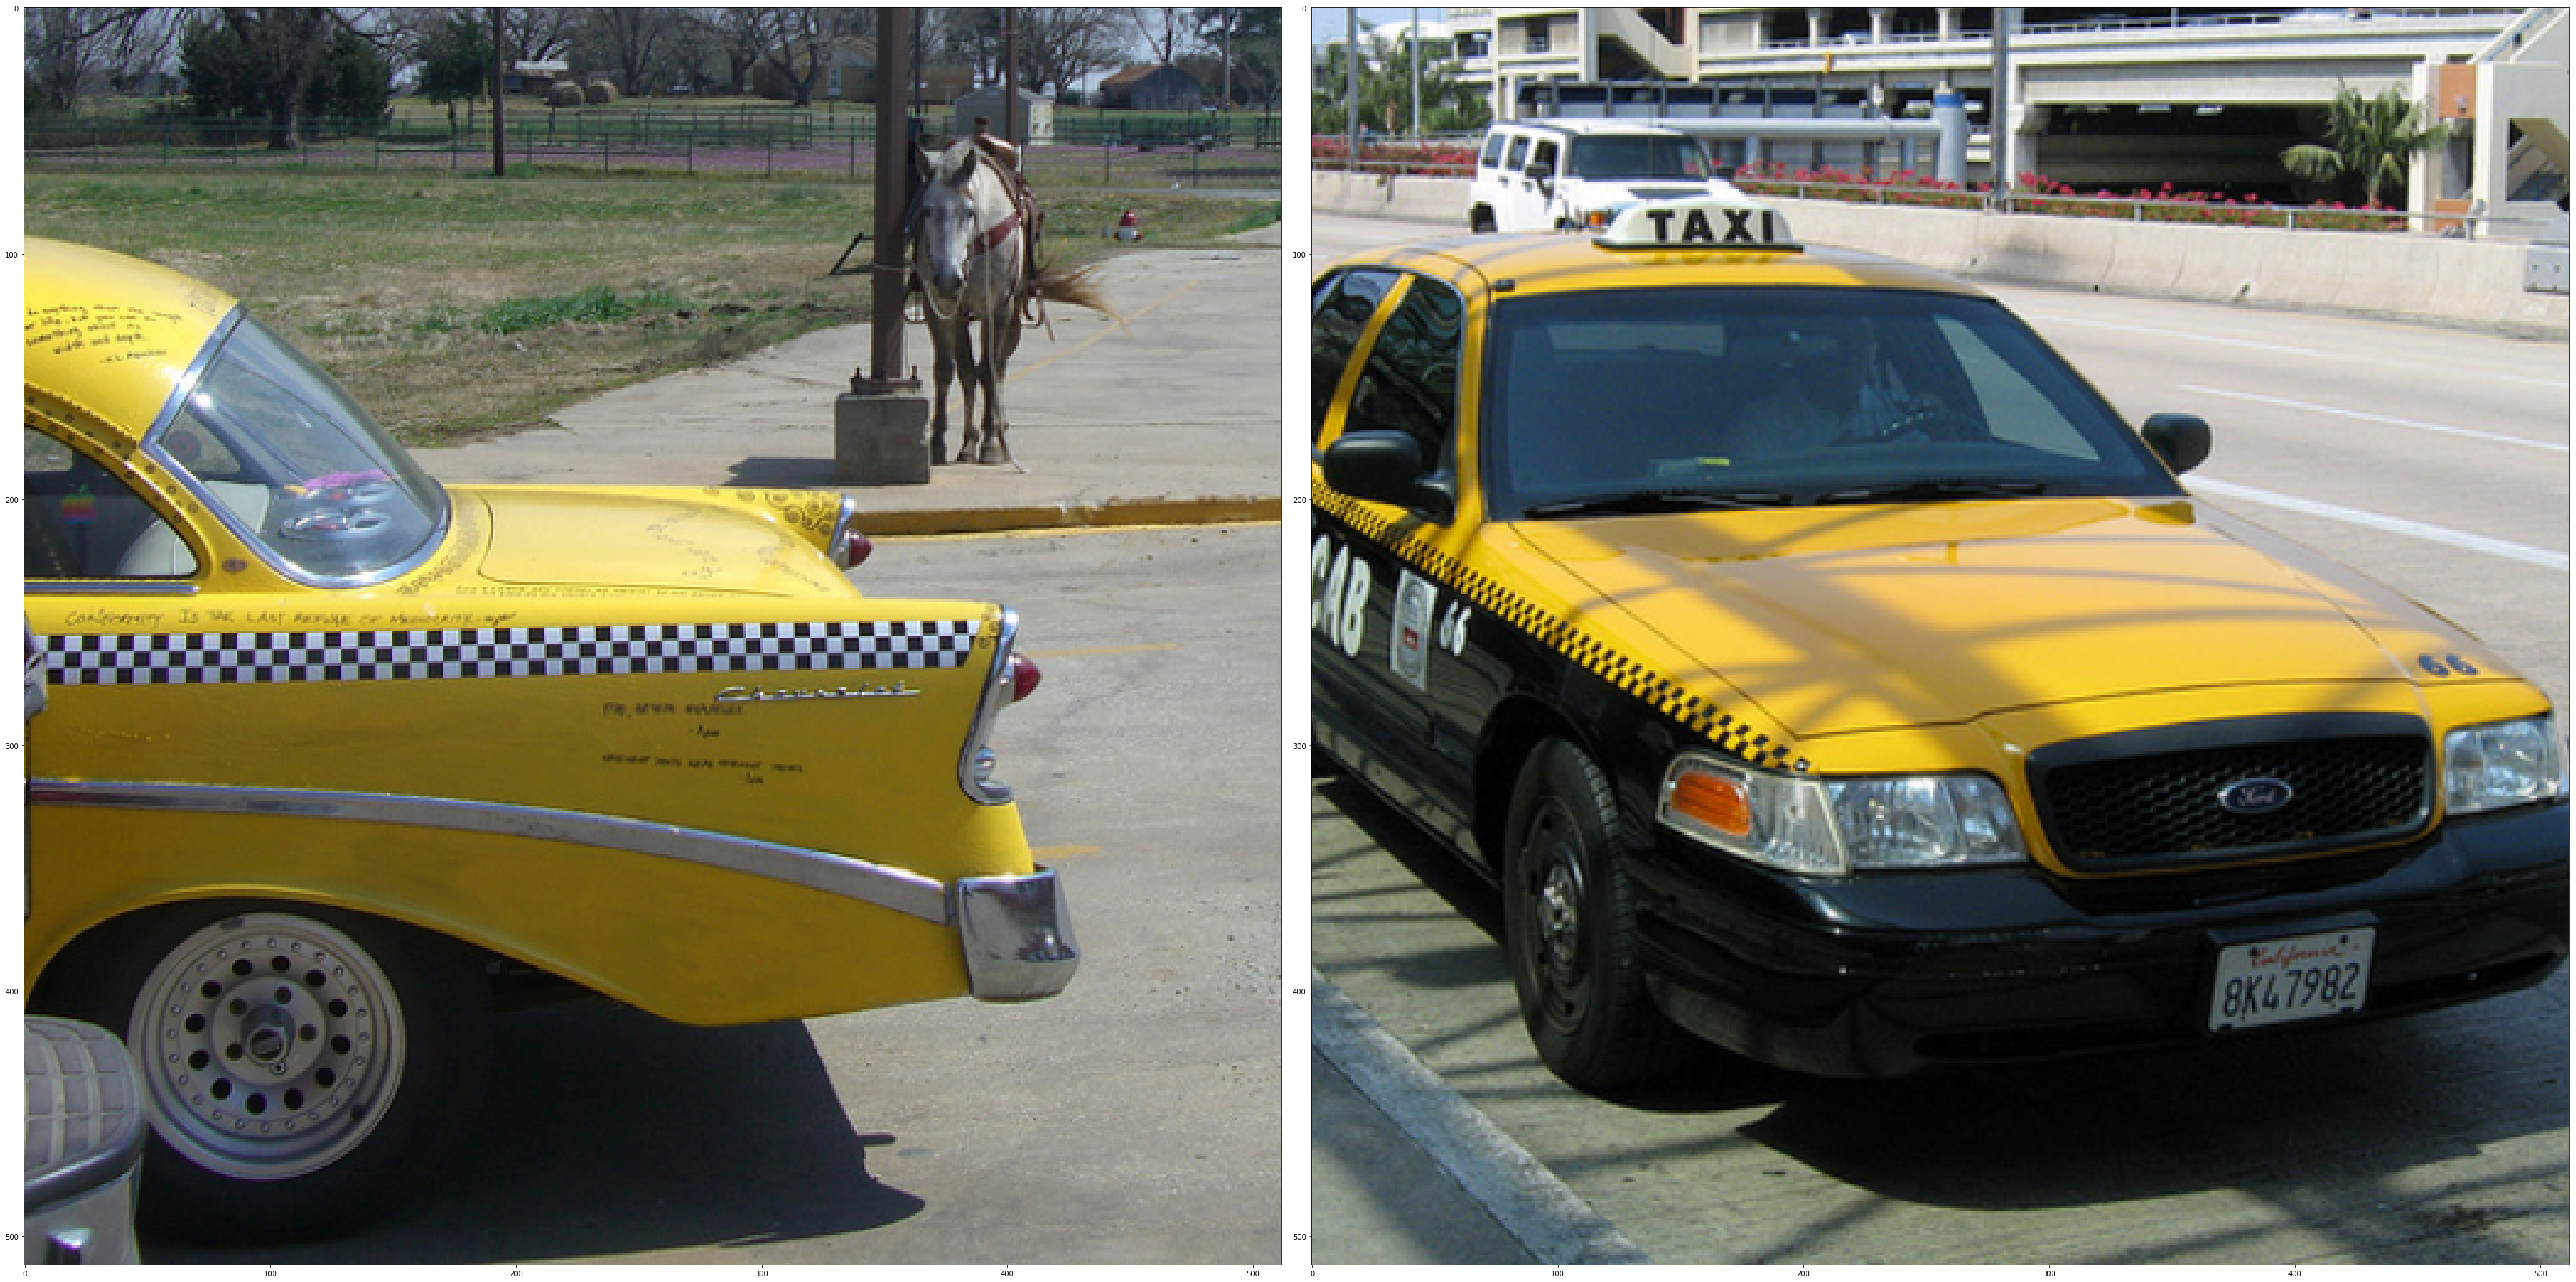

In [8]:
imagenet_val = datasets.ImageFolder(
    "/var/tmp/namespace/hendrycks/imagenet/val/",
    transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        normalize,
    ])
)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(50, 70)
fig.tight_layout()

show_image(imagenet_val[23423][0], ax[0])
show_image(imagenet_val[23445][0], ax[1])


In [9]:
        
# def make_block(hidden_planes=64):
#     return nn.Sequential(
#         nn.Conv2d(3, hidden_planes, kernel_size=5, stride=1, padding=2),
#         nn.BatchNorm2d(hidden_planes),
#         nn.ReLU(),
#         nn.Conv2d(hidden_planes, hidden_planes, kernel_size=5, stride=1, padding=2),
#         nn.BatchNorm2d(hidden_planes),
#         nn.ReLU(),
#         nn.Conv2d(hidden_planes, hidden_planes, kernel_size=5, stride=1, padding=2),
#         nn.BatchNorm2d(hidden_planes),
#         nn.ReLU(),
#         nn.Conv2d(hidden_planes, 3, kernel_size=3, stride=1, padding=1)
#     )

class Block1(torch.nn.Module):
    def __init__(self, hidden_planes):
        super(Block1, self).__init__()
        self.hidden_planes = hidden_planes
        
        K = random.choice([1, 3, 5])
        D = random.choice([1, 2, 3])
        P = int(((K - 1) / 2) * D)
                
        self.conv1 = nn.Conv2d(3, hidden_planes, kernel_size=K, stride=1, padding=P, dilation=D)
        self.bn1   = nn.BatchNorm2d(hidden_planes)
        self.act1  = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden_planes, hidden_planes, kernel_size=K, stride=1, padding=P, dilation=D)
        self.bn2   = nn.BatchNorm2d(hidden_planes)
        self.act2  = nn.ReLU()
        self.conv3 = nn.Conv2d(hidden_planes, hidden_planes, kernel_size=K, stride=1, padding=P, dilation=D)
        self.bn3   = nn.BatchNorm2d(hidden_planes)
        self.act3  = nn.ReLU()
        self.conv4 = nn.Conv2d(hidden_planes, 3, kernel_size=K, stride=1, padding=P, dilation=D)
        self.bn4   = nn.BatchNorm2d(3)
    
    def forward(self, x):
        
        orig_shape = x.shape
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = x[:,torch.randperm(64)]
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = x[:,torch.randperm(64)]
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
                
        return x
        

class ResNet(torch.nn.Module):
    def __init__(self, epsilon=0.2, hidden_planes=64):
        super(ResNet, self).__init__()
        
        self.epsilon = epsilon
        self.hidden_planes = hidden_planes
        
        # self.block1 = make_block(hidden_planes=hidden_planes)
        # self.block2 = make_block(hidden_planes=hidden_planes)
        # self.block3 = make_block(hidden_planes=hidden_planes)
        # self.block4 = make_block(hidden_planes=hidden_planes)
        # self.block5 = make_block(hidden_planes=hidden_planes)
        # self.block6 = make_block(hidden_planes=hidden_planes)
        
        self.block1 = Block1(hidden_planes=hidden_planes)
        self.block2 = Block1(hidden_planes=hidden_planes)
        self.block3 = Block1(hidden_planes=hidden_planes)
        self.block4 = Block1(hidden_planes=hidden_planes)
        self.block5 = Block1(hidden_planes=hidden_planes)
        self.block6 = Block1(hidden_planes=hidden_planes)
    
    def forward_old(self, x):
                
        x = (self.block1(x) * self.epsilon) + x
        x = (self.block2(x) * self.epsilon) + x
        x = (self.block3(x) * self.epsilon) + x
        
        if random.random() < 0.5:
            x = (self.block4(x) * self.epsilon) + x
        
        if random.random() < 0.5:
            x = (self.block5(x) * self.epsilon) + x
        
        if random.random() < 0.5:
            x = (self.block6(x) * self.epsilon) + x
        
        return x

    def forward_old2(self, x):
        
        num_splits = random.choice([1, 2, 3, 6])
        per_split = 6 / num_splits
        blocks = [self.block1, self.block2, self.block3, self.block4, self.block5, self.block6]
        random.shuffle(blocks)
        
        split_blocks = [blocks[int(round(per_split * i)): int(round(per_split * (i + 1)))] for i in range(num_splits)]
        
        for group in split_blocks:
            group_len = len(group)
            
            branch = x
            for block in group:
                branch = block(branch) * self.epsilon
                branch = branch + ((torch.rand_like(branch) - 0.5) * random.random() * 0.5)
            x = x + branch 
                
        return x
    
    def eval_random_block(self, x):
        blocks = [self.block1, self.block2, self.block3, self.block4, self.block5, self.block6]
        block = random.choice(blocks)
        return block(x)
    
    def forward(self, x):
        
        for section in range(6):
            
            splits = 3 #random.choice([1,2,3])
            blocks = 3 #random.choice([1,2,3])
            split_output = torch.zeros_like(x)
            
            for split in range(splits):
                branch = x.clone()
                for block in range(blocks):
                    branch = self.eval_random_block(x)
                
                split_output = split_output + (branch * self.epsilon / splits)
            
            x = split_output + x
            
        return x



In [ ]:

fig, ax = plt.subplots(4,2)
fig.set_size_inches(50, 70)
fig.tight_layout()

with torch.no_grad():
    for i in range(4):

        net = ResNet(epsilon=0.75).train().cuda()

        im1 = imagenet_val[23423][0].unsqueeze(0).cuda()
        im2 = imagenet_val[23445][0].unsqueeze(0).cuda()

        result1 = net(im1).detach()[0].cpu()
        result2 = net(im2).detach()[0].cpu()

        show_image(result1, ax[i][0])
        show_image(result2, ax[i][1])
